In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
# nltk.download('wordnet')
from textblob import Word
from nltk.stem import WordNetLemmatizer 
import glob
import pandas as pd
import codecs
import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from gensim.models.keyedvectors import KeyedVectors

from keras.layers import Embedding
from keras.layers import Dense, Input
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from keras.layers import Dense, Activation, Multiply, Add, LSTM, LeakyReLU
from keras.layers import Input, Dense, Dropout
from keras.optimizers import Adam
from keras.regularizers import l2
from kutilities.layers import AttentionWithContext
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score

Using TensorFlow backend.


In [2]:
label_data = pd.read_csv('yelp_review_with_labels.csv')
label_data.head(5)


,business_id,name,city,state,stars,review_count,categories,review_id,review_stars,useful,funny,cool,text,date,polarity
0,bPBZEDuHbE-I7bxUWIYMhQ,Oishii Sushi,Calgary,AB,3.0,91,"Japanese, Restaurants, Sushi Bars",rFfxQEA9wCmRYyqDSv1ecQ,4,0,1,0,Went here for all you can eat sushi dinner! Bo...,2017-11-11 19:16:19,0
1,bPBZEDuHbE-I7bxUWIYMhQ,Oishii Sushi,Calgary,AB,3.0,91,"Japanese, Restaurants, Sushi Bars",MccdpC7TvFCTKO5Pdx37PA,1,1,1,0,The service was okay when it was present. The ...,2016-02-27 08:03:55,0
2,bPBZEDuHbE-I7bxUWIYMhQ,Oishii Sushi,Calgary,AB,3.0,91,"Japanese, Restaurants, Sushi Bars",OS_uA1Dm7iV4NLGcgtZ9qw,5,0,0,1,Went here on the weekend for lunch and food/se...,2015-11-09 23:03:17,1
3,bPBZEDuHbE-I7bxUWIYMhQ,Oishii Sushi,Calgary,AB,3.0,91,"Japanese, Restaurants, Sushi Bars",q37oYWTdZmXC8Z26nTR87Q,5,0,0,0,I've eaten here twice now and I'm really impre...,2017-07-12 16:52:23,1
4,bPBZEDuHbE-I7bxUWIYMhQ,Oishii Sushi,Calgary,AB,3.0,91,"Japanese, Restaurants, Sushi Bars",5w3lP3O8ZUO9kOTfQFi8pQ,1,1,1,1,Not good for groups.\n We came here tonight fo...,2016-04-04 05:57:54,0


#### Data Cleaning

In [3]:
#lowercase conversion  
label_data['text'] = [i.lower() for i in label_data['text']]
label_data['text'][0]

"went here for all you can eat sushi dinner! bottomline: best all you can eat sushi in calgary! it costs $26 per person for sushi and sashimi and $32 for the deluxe menu which includes oysters and tataki. \n\nwe went a little overboard with ordering rolls (to the point that the waiter asked if we were sure we can finish haha) and then regretted it shortly after! there is a charge for unfinished food so it was a little stressful haha \n\nwe ordered the mango dragon roll (prawn tempura and avacado with mango), philadelphia roll, spicy salmon roll, beef udon, miso soup, salmon and tuna sashimi, salmon rose and prawn tempura. out of these my favourites were the spicy salmon and the mango dragon roll. i didn't love the tempura personally because it was a bit soggy. didn't have room for dessert after all this food so can't comment on that haha"

In [4]:
#stopword removal 
from nltk.corpus import stopwords
nltk.download('stopwords')

Stopwords = set(stopwords.words('english'))

label_data["text"] = label_data["text"].apply(lambda text: " ".join([word for word in str(text).split() if word not in Stopwords]))
label_data['text'][0]

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/f6rzpfu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


"went eat sushi dinner! bottomline: best eat sushi calgary! costs $26 per person sushi sashimi $32 deluxe menu includes oysters tataki. went little overboard ordering rolls (to point waiter asked sure finish haha) regretted shortly after! charge unfinished food little stressful haha ordered mango dragon roll (prawn tempura avacado mango), philadelphia roll, spicy salmon roll, beef udon, miso soup, salmon tuna sashimi, salmon rose prawn tempura. favourites spicy salmon mango dragon roll. love tempura personally bit soggy. room dessert food can't comment haha"

In [5]:
#punctuation removal + number removal + space/blank removal 
import string
import re
def clean_text(text):
    # remove numbers
    text_nonum = re.sub(r'\d+', '', text)
    # remove punctuations and convert characters to lower case
    text_nopunct = "".join([char for char in text_nonum if char not in string.punctuation]) 
    # substitute multiple whitespace with single whitespace
    # remove leading and trailing whitespaces
    text_no_doublespace = re.sub('\s+', ' ', text_nopunct).strip()
    return text_no_doublespace

label_data["text"]=label_data['text'].map(lambda text: clean_text(text))

In [6]:
#lemmatization
lemmatizer = WordNetLemmatizer()

# Lemmatize final review format
label_data['lemmatized_text'] = label_data['text'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

In [8]:
#stemming
from nltk.stem.porter import PorterStemmer

stemmer = PorterStemmer()

label_data["stemmed_text"] = label_data["lemmatized_text"].apply(lambda text: " ".join([stemmer.stem(word) for word in text.split()]))

In [9]:
X=label_data["stemmed_text"]
y=label_data["polarity"]

In [10]:
from sklearn.model_selection import train_test_split
X_train1,X_test1,y_train1,y_test1=train_test_split(X,y,test_size=0.3,random_state=1)

In [11]:
np.unique(y_train1, return_counts = True)

(array([0, 1]), array([3959, 7779]))

In [12]:
np.unique(y_test1, return_counts = True)

(array([0, 1]), array([1728, 3303]))

#### Tokenizer + Pad Sequence

In [13]:
from keras.preprocessing.text import Tokenizer
# Number of words to consider as features
# restrict the yelp reviews to the top 10000 most common words
max_features=20000
# Tokenize the sentences
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train1)+list(X_test1))
word_index = tokenizer.word_index
X_train = tokenizer.texts_to_sequences(X_train1)
X_test = tokenizer.texts_to_sequences(X_test1)

In [14]:
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
# cut reviews after 200 words
maxlen=300
X_train=pad_sequences(X_train,maxlen=maxlen) #training data contains a list of list of numbers 
X_test=pad_sequences(X_test,maxlen=maxlen) #each list has the same numbers 

y_train = to_categorical(y_train1)
y_test = to_categorical(y_test1)

In [15]:
print("X_train",X_train.shape)
print("y_train",y_train.shape)

X_train (11738, 300)
y_train (11738, 2)


In [16]:
print("X_test",X_test.shape)
print("y_test",y_test.shape)

X_test (5031, 300)
y_test (5031, 2)


#### Custom Words Embedded Vectors

In [17]:
WORD_NUM = 20000
MAX_SEQUENCE_LENGTH = 300

In [18]:
#create word vector model from our training data
wvmodel = Word2Vec(size=300,
                    min_count=5,
                    workers=3)


wvmodel.build_vocab(X_train1)


wvmodel.train(X_train1,
              total_examples = wvmodel.corpus_count,
              epochs = wvmodel.iter)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  # This is added back by InteractiveShellApp.init_path()


(3078029, 17812205)

In [19]:
EMBEDDING_DIM = 300 
vocab = min((len(word_index), WORD_NUM))
embed_matrix = np.zeros((vocab, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= WORD_NUM:
        continue
    try:
        word_vec = wvmodel[word]
        embed_matrix[i] = word_vec
    except KeyError:
        embed_matrix[i] = np.random.normal(0, np.sqrt(0.25), EMBEDDING_DIM)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [20]:
embed_matrix.shape

(20000, 300)

In [38]:
#hyperparameters initialize
LAB_NUMBER = 2 # number of labels, 20 in this case
WREG = 0.0001 # embedding regularization
CREG = 0.00001 # CNN regularization
RREG = 0.00001 # LSTM regularization
DREG = 0.00001 # Fully connected regularization
WDROP_RATE = 0.50 # embedding dropout
CDROP_RATE = 0.3 # CNN dropout
RDROP_RATE = 0.3 # LSTM dropout
DDROP_RATE = 0.3 # fully connected dropout
CHIDDEN_SIZE = 32 # CNN size
RHIDDEN_SIZE = 64 # LSTM size 
DHIDDEN_SIZE = 128 # fully connected size
SEQ_LEN = MAX_SEQUENCE_LENGTH
EPOCH = 100
BATCH_SIZE = 64

#### Model Design

In [39]:
#embedding layer from word2vec custom embeddings
embed = Embedding(vocab,
                  EMBEDDING_DIM,
                  weights=[embed_matrix],
                  trainable=True, 
                  embeddings_regularizer=l2(WREG))

#input and CNNs
inputs = Input(shape=(SEQ_LEN,), dtype='int32')
embed_sequence = embed(inputs)

embed_sequence = Dropout(WDROP_RATE)(embed_sequence)


cnn1 = Conv1D(filters = CHIDDEN_SIZE, 
              kernel_regularizer=l2(CREG), 
              kernel_size=(3), 
              padding= "same", 
              strides=1)(embed_sequence)
cnn1 = Activation('relu')(cnn1)
cnn1 = MaxPooling1D(5)(cnn1)
cnn1 = Dropout(CDROP_RATE)(cnn1)


cnn2 = Conv1D(filters = CHIDDEN_SIZE, 
              kernel_regularizer=l2(CREG), 
              kernel_size=(5), 
              padding="valid", 
              strides=1)(cnn1)

cnn2 = Activation('relu')(cnn2)
cnn2 = MaxPooling1D(5)(cnn2)
cnn2 = Dropout(CDROP_RATE)(cnn2)


#LSTM
lstm1 = LSTM(RHIDDEN_SIZE, 
             kernel_regularizer=l2(RREG))(cnn2)
# lstm1 = AttentionWithContext()(lstm1)
lstm1 = Dropout(RDROP_RATE)(lstm1)

#Feedforward and softmax
out = Dense(DHIDDEN_SIZE,
            kernel_regularizer=l2(DREG))(lstm1)
out = LeakyReLU()(out)
out = Dropout(DDROP_RATE)(out)


prediction = Dense(LAB_NUMBER, 
                   activation = 'softmax')(out)

model = Model(inputs, prediction)
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 300)               0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 300, 300)          6000000   
_________________________________________________________________
dropout_16 (Dropout)         (None, 300, 300)          0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 300, 32)           28832     
_________________________________________________________________
activation_7 (Activation)    (None, 300, 32)           0         
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 60, 32)            0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 60, 32)            0   

In [40]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['acc'])

#early stopping set up
callbacks = [EarlyStopping(monitor = 'val_acc', patience = 3),
             ModelCheckpoint(filepath = 'best_model.h5', monitor= 'val_acc', save_best_only = True)]

#training
history = model.fit(X_train, y_train, 
          validation_data = (X_test, y_test),
          epochs = EPOCH,
          verbose = 1,
          callbacks = callbacks,
          batch_size = BATCH_SIZE)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 11738 samples, validate on 5031 samples
Epoch 1/100
11738/11738 [==============================] - 39s 3ms/step - loss: 114.7221 - acc: 0.6581 - val_loss: 84.9038 - val_acc: 0.6565
Epoch 2/100
11738/11738 [==============================] - 37s 3ms/step - loss: 65.1571 - acc: 0.6668 - val_loss: 48.5384 - val_acc: 0.7082
Epoch 3/100
11738/11738 [==============================] - 37s 3ms/step - loss: 37.4017 - acc: 0.7510 - val_loss: 28.0216 - val_acc: 0.7963
Epoch 4/100
11738/11738 [==============================] - 38s 3ms/step - loss: 21.7248 - acc: 0.8052 - val_loss: 16.3842 - val_acc: 0.8167
Epoch 5/100
11738/11738 [==============================] - 38s 3ms/step - loss: 12.7577 - acc: 0.8277 - val_loss: 9.6970 - val_acc: 0.8229
Epoch 6/100
11738/11738 [==============================] - 38s 3ms/step - loss: 7.5866 - acc: 0.8396 - val_loss: 5.8402 - val_acc: 0.8273
Epoch 7/100
11738/11738 [==============================] - 38s 3ms/step - loss: 4.5947 - acc: 0.8530 - val_loss: 

#### Differrent Test Run on Different Hyperparameter Values

In [38]:
#results on original data 
[test_cost, test_acc] = model.evaluate(X_test, y_test)
print("Evaluation result on Test Data : Cost = {}, accuracy = {}".format(test_cost, (test_acc*100)))

5031/5031 [==============================] - 1s 295us/step
Evaluation result on Test Data : Cost = 0.8431442160832434, accuracy = 81.01769089698792


In [54]:
#on clean and stemmed data
[test_cost, test_acc] = model.evaluate(X_test, y_test)
print("Evaluation result on Test Data : Cost = {}, accuracy = {}".format(test_cost, (test_acc*100)))

5031/5031 [==============================] - 1s 293us/step
Evaluation result on Test Data : Cost = 0.7874462646048104, accuracy = 80.58040142059326


In [70]:
#on clean and lemmatized data
[test_cost, test_acc] = model.evaluate(X_test, y_test)
print("Evaluation result on Test Data : Cost = {}, accuracy = {}".format(test_cost, (test_acc*100)))

5031/5031 [==============================] - 1s 292us/step
Evaluation result on Test Data : Cost = 0.7897152657822571, accuracy = 81.07731938362122


In [121]:
# on clean and lemmatized data - new values of drop out and batch size (batch size 32, 10000,200)
[test_cost, test_acc] = model.evaluate(X_test, y_test)
print("Evaluation result on Test Data : Cost = {}, accuracy = {}".format(test_cost, (test_acc*100)))

5031/5031 [==============================] - 3s 503us/step
Evaluation result on Test Data : Cost = 2.570745726935884, accuracy = 82.1506679058075


In [82]:
#on clean and lemmatized data - new values of drop out and batch size 16
[test_cost, test_acc] = model.evaluate(X_test, y_test)
print("Evaluation result on Test Data : Cost = {}, accuracy = {}".format(test_cost, (test_acc*100)))

5031/5031 [==============================] - 2s 328us/step
Evaluation result on Test Data : Cost = 0.7444702595253158, accuracy = 80.65990805625916


In [109]:
#on clean and lemmatized data - new values of drop out and batch size 32, (20000 maxfeature and 300 maxlen)
[test_cost, test_acc] = model.evaluate(X_test, y_test)
print("Evaluation result on Test Data : Cost = {}, accuracy = {}".format(test_cost, (test_acc*100)))

5031/5031 [==============================] - 3s 525us/step
Evaluation result on Test Data : Cost = 0.7741266280039478, accuracy = 81.89226984977722


In [113]:
#on clean and lemmatized data - new values of drop out and batch size 64, (20000 maxfeature and 300 maxlen)
[test_cost, test_acc] = model.evaluate(X_test, y_test)
print("Evaluation result on Test Data : Cost = {}, accuracy = {}".format(test_cost, (test_acc*100)))

5031/5031 [==============================] - 2s 481us/step
Evaluation result on Test Data : Cost = 1.7333396131299026, accuracy = 82.28980302810669


In [117]:
#on clean and lemmatized data - new values of drop out and batch size 128, (20000 maxfeature and 300 maxlen)
[test_cost, test_acc] = model.evaluate(X_test, y_test)
print("Evaluation result on Test Data : Cost = {}, accuracy = {}".format(test_cost, (test_acc*100)))

5031/5031 [==============================] - 3s 504us/step
Evaluation result on Test Data : Cost = 16.531152650912365, accuracy = 82.28980302810669


In [125]:
#on clean and lemmatized data - new values of drop out and batch size 64, dropout = 0.5, (20000 maxfeature and 300 maxlen)
[test_cost, test_acc] = model.evaluate(X_test, y_test)
print("Evaluation result on Test Data : Cost = {}, accuracy = {}".format(test_cost, (test_acc*100)))

5031/5031 [==============================] - 3s 521us/step
Evaluation result on Test Data : Cost = 1.6716193641731976, accuracy = 82.46869444847107


In [24]:
#on clean and lemmatized data - new values of drop out and batch size 64, dropout = 0.5, (20000 maxfeature and 300 maxlen)
[test_cost, test_acc] = model.evaluate(X_test, y_test)
print("Evaluation result on Test Data : Cost = {}, accuracy = {}".format(test_cost, (test_acc*100)))

5031/5031 [==============================] - 2s 488us/step
Evaluation result on Test Data : Cost = 3.6696809793509066, accuracy = 82.64758586883545


In [28]:
#on clean and lemmatized data - new values of drop out and batch size 32, dropout = 0.5, 0.3 (20000 maxfeature and 300 maxlen)
[test_cost, test_acc] = model.evaluate(X_test, y_test)
print("Evaluation result on Test Data : Cost = {}, accuracy = {}".format(test_cost, (test_acc*100)))

5031/5031 [==============================] - 3s 505us/step
Evaluation result on Test Data : Cost = 0.8871463607234762, accuracy = 82.50844478607178


In [33]:
#on clean and lemmatized data - new values of drop out and batch size 34, dropout = 0.5, 0.3, 0.4 (20000 maxfeature and 300 maxlen)
[test_cost, test_acc] = model.evaluate(X_test, y_test)
print("Evaluation result on Test Data : Cost = {}, accuracy = {}".format(test_cost, (test_acc*100)))

5031/5031 [==============================] - 2s 477us/step
Evaluation result on Test Data : Cost = 0.8606761703195498, accuracy = 82.46869444847107


In [47]:
# predict probabilities for test set
yhat_probs = model.predict(X_test, verbose=0)
# predict crisp classes for test set
yhat_classes = np.argmax(yhat_probs,axis=1)

In [57]:
# # accuracy: (tp + tn) / (p + n)
# accuracy = accuracy_score(y_test[:,1], yhat_classes)
# print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test[:,1], yhat_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test[:,1], yhat_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test[:,1], yhat_classes)
print('F1 score: %f' % f1)

Precision: 0.851237
Recall: 0.885256
F1 score: 0.867913


In [60]:
# train_acc = history.history['acc']
# test_acc = history.history['val_acc']
# df = pd.DataFrame()
# df['train_acc'] = train_acc
# df['test_acc'] = test_acc
# df.to_csv('hybrid1.csv')

Text(0.5, 1.0, 'Accuracy Curves')

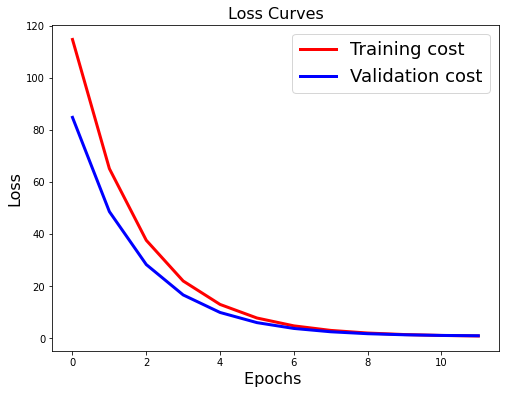

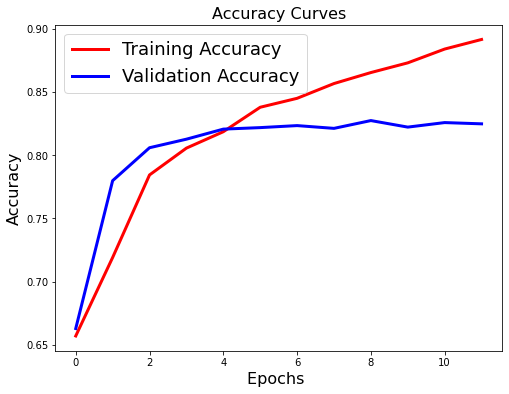

In [34]:
#Plot cost
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training cost', 'Validation cost'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
#Plot accuracy
plt.figure(figsize=[8,6])
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [63]:
#All 3 model results in the same csv for comparison plot
df = pd.read_csv('model_compared.csv')

In [64]:
df

,epoch,rnn_train_acc,rnn_val_acc,hybrid1_train_acc,hybrid1_val_acc,hybrid2_train_acc,hybrid2_val_acc
0,1,0.698296,0.785775,0.658119,0.656530,0.672950,0.785349
1,2,0.791374,0.810903,0.666809,0.708209,0.786688,0.781942
2,3,0.816507,0.801959,0.750980,0.796263,0.801278,0.814310
3,4,0.833972,0.810903,0.805163,0.816736,0.816720,0.804940
4,5,0.844089,0.821124,0.827654,0.822898,0.822151,0.813884
5,6,0.852077,0.829216,0.839581,0.827271,0.829712,0.816865
6,7,0.854952,0.836457,0.853041,0.828265,0.840043,0.823680
7,8,0.860383,0.823680,0.861816,0.828464,0.837274,0.828791
8,9,0.868158,0.828790,0.871017,0.836414,0.834931,0.828791
9,10,0.870288,0.831346,0.878770,0.828861,0.856762,0.829642


Text(0.5, 1.0, 'Training Accuracy from Different Models')

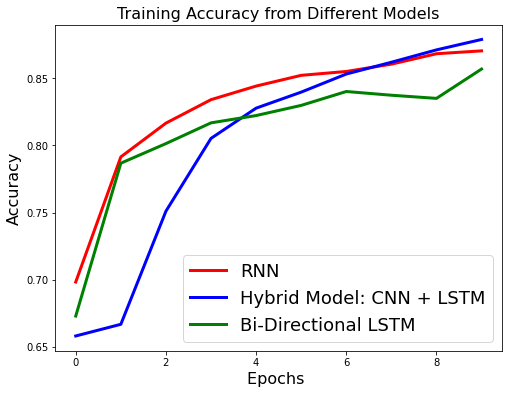

In [69]:
#Plot accuracy
plt.figure(figsize=[8,6])
plt.plot(df['rnn_train_acc'],'r',linewidth=3.0)
plt.plot(df['hybrid1_train_acc'],'b',linewidth=3.0)
plt.plot(df['hybrid2_train_acc'],'g',linewidth=3.0)
plt.legend(['RNN', 'Hybrid Model: CNN + LSTM', 'Bi-Directional LSTM'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Training Accuracy from Different Models',fontsize=16)

Text(0.5, 1.0, 'Validation Accuracy from Different Models')

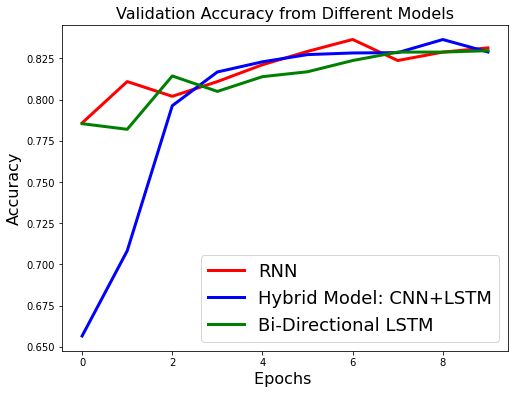

In [70]:
#Plot accuracy
plt.figure(figsize=[8,6])
plt.plot(df['rnn_val_acc'],'r',linewidth=3.0)
plt.plot(df['hybrid1_val_acc'],'b',linewidth=3.0)
plt.plot(df['hybrid2_val_acc'],'g',linewidth=3.0)
plt.legend(['RNN', 'Hybrid Model: CNN+LSTM', 'Bi-Directional LSTM'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Validation Accuracy from Different Models',fontsize=16)